In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression, SelectFromModel

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

In [2]:
df = pd.read_csv("../data/raw/numerical.csv")

In [3]:
df.head()

date  Tax Effect Of Unusual Items  Tax Rate For Calcs  \
0  2024-12-31                          0.0               0.237   
1  2023-12-31                          0.0               0.241   
2  2022-12-31                          0.0               0.245   
3  2021-12-31                          0.0               0.234   
4  2020-12-31                          NaN                 NaN   

   Normalized EBITDA  Total Unusual Items  \
0       1.690800e+09                  NaN   
1       1.710100e+09                  NaN   
2       1.630900e+09                  NaN   
3       1.388200e+09                  NaN   
4                NaN            1400000.0   

   Total Unusual Items Excluding Goodwill  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                               1400000.0   

   Net Income From Continuing Operation Net Minority Interest  \
0                                       1.150600e+09            
1                                       1.155000e+09            
2                                       1.086900e+09            
3                                       9.250000e+08            
4                                                NaN            

   Reconciled Depreciation  Reconciled Cost Of Revenue        EBITDA  ...  \
0              175400000.0                4.144100e+09  1.690800e+09  ...   
1              177300000.0                3.992200e+09  1.710100e+09  ...   
2              176600000.0                3.764800e+09  1.630900e+09  ...   
3              170700000.0                3.233700e+09  1.388200e+09  ...   
4                      NaN                         NaN           NaN  ...   

   militaryContract  nuclear  pesticides  palmOil   coal  tobacco  \
0             False    False       False    False  False    False   
1             False    False       False    False  False    False   
2             False    False       False    False  False    False   
3             False    False       False    False  False    False   
4             False    False       False    False  False    False   

   percentAumCovered  sustainRank  responsible  sustainScore  
0                NaN          NaN          NaN           NaN  
1                NaN          NaN          NaN           NaN  
2                NaN          NaN          NaN           NaN  
3                NaN          NaN          NaN           NaN  
4                NaN          NaN          NaN           NaN  

[5 rows x 392 columns]

In [4]:
front_columns = ['symbol', 'date', 'companySize', 'region', 'totalEsg', 'marketCap']
to_drop = ['Ticker', 'shortName', 'longName', 'cumulativeMarketCapPercentage', 'ratingMonth', 'ratingYear', 'peerCount', 'highestControversy', 'maxAge'] # duplicate info & unnecessary columns

all_columns = df.columns.tolist()
new_column_order = front_columns + [col for col in all_columns if col not in front_columns and col not in to_drop] 

# Reindex the DataFrame with the new column order
df = df[new_column_order]

In [5]:
df.head()

symbol        date companySize         region  totalEsg     marketCap  \
0   FAST  2024-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
1   FAST  2023-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
2   FAST  2022-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
3   FAST  2021-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
4   FAST  2020-12-31     Mid-Cap  north_america     25.04  4.367976e+10   

   Tax Effect Of Unusual Items  Tax Rate For Calcs  Normalized EBITDA  \
0                          0.0               0.237       1.690800e+09   
1                          0.0               0.241       1.710100e+09   
2                          0.0               0.245       1.630900e+09   
3                          0.0               0.234       1.388200e+09   
4                          NaN                 NaN                NaN   

   Total Unusual Items  ...  militaryContract  nuclear  pesticides  palmOil  \
0                  NaN  ...             False    False       False    False   
1                  NaN  ...             False    False       False    False   
2                  NaN  ...             False    False       False    False   
3                  NaN  ...             False    False       False    False   
4            1400000.0  ...             False    False       False    False   

    coal  tobacco  percentAumCovered  sustainRank  responsible  sustainScore  
0  False    False                NaN          NaN          NaN           NaN  
1  False    False                NaN          NaN          NaN           NaN  
2  False    False                NaN          NaN          NaN           NaN  
3  False    False                NaN          NaN          NaN           NaN  
4  False    False                NaN          NaN          NaN           NaN  

[5 rows x 383 columns]

In [6]:
df.shape

(4646, 383)

In [7]:
df['symbol'].nunique()

1012

In [8]:
# Create a latest_date feature to align different EOY financial dates
df['latest_date'] = df.groupby('symbol')['date'].transform('max')

In [9]:
df['latest_date'].value_counts()

latest_date
2024-12-31    2603
2024-03-31     925
2023-12-31     444
2024-06-30     180
2024-09-30     156
2025-01-31      74
2024-02-29      58
2024-08-31      44
2024-07-31      34
2024-10-31      33
2024-01-31      28
2024-05-31      25
2024-04-30      15
2023-03-31      11
2022-12-31      11
2024-11-30       5
Name: count, dtype: int64

In [10]:
df['latest_year'] = df['latest_date'].apply(lambda x: x.split('-')[0])

In [11]:
df_news = pd.read_csv("../data/processed/news_sentiment.csv") # loading news sentiment data to merge later

In [12]:
df_news.head()

symbol                                       cleaned_text  \
0  000270.KS  ['The Integrated Greenhouse Gas Information Sy...   
1    0005.HK  ['We recently published a list of 12 Best ADR ...   
2  000660.KS  ['According to a new report from SP Global, th...   
3  005380.KS  ['The series, now viewable on YouTube, present...   
4  005490.KS  ['0858 October 22, 2024 New Delhi, October 22,...   

                                       raw_sentiment  sentiment_ratio_all  \
0  [{'label': 'positive', 'score': 0.708621323108...            -0.142857   
1  [{'label': 'negative', 'score': 0.481453657150...            -0.500000   
2  [{'label': 'positive', 'score': 0.569136857986...             0.428571   
3  [{'label': 'neutral', 'score': 0.7179769873619...             0.166667   
4  [{'label': 'neutral', 'score': 0.5735214352607...             0.000000   

   sentiment_ratio_extremes  weighted_sentiment_avg  \
0                 -0.333333               -0.035744   
1                 -1.000000               -0.317086   
2                  1.000000                0.256201   
3                  1.000000                0.122389   
4                       NaN                0.000000   

   weighted_sentiment_norm_conf  
0                     -0.061384  
1                     -0.410726  
2                      0.386590  
3                      0.174893  
4                      0.000000

## Data Cleaning

### Assessing Missingness Patterns

In [13]:
df.shape

(4646, 385)

In [14]:
# Drop features with more than 70% missing values, as they offer too little information to be imputed
pct_null = df.isnull().mean()
df = df.drop(columns=pct_null[pct_null > 0.7].index.tolist())
df.shape

(4646, 224)

### Assessing constant features

Features with zero or very low variance provide little information and can be removed.

In [15]:
# Calculate variance for each numerical column
feature_variance = df.var(numeric_only=True)
feature_variance.sort_values(ascending=True).head(10)

Tax Rate For Calcs                     6.051133e-03
governanceScore                        8.557575e+00
socialScore                            1.242530e+01
environmentScore                       3.344256e+01
totalEsg                               6.903441e+01
Diluted EPS                            1.500915e+07
Basic EPS                              1.514600e+07
Treasury Shares Number                 1.323453e+19
Otherunder Preferred Stock Dividend    3.736201e+19
Stock Based Compensation               1.700235e+20
dtype: float64

In [16]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(df.select_dtypes(include=[np.number]).fillna(0))
constant_feats = df.select_dtypes(include=[np.number]).columns[~vt.get_support()]
constant_feats

Index(['Tax Rate For Calcs'], dtype='object')

In [17]:
df = df.drop(columns=constant_feats)

In [18]:
df.shape

(4646, 223)

### Missing Value Imputation

Step 1: Company‑level ffill/bfill (and/or rolling)

Step 2: Peer‑group imputation (region + company size + year)

Step 3: Global/statistical imputer (median) for any stragglers

In [19]:
# defining columns that should be imputed
df_sorted = df.sort_values(by=['symbol', 'latest_year'], ascending=True)
meta_numeric = ['date', 'latest_date', 'latest_year', 'totalEsg', 'environmentScore', 'socialScore', 'governanceScore']

cols_to_impute = df_sorted.select_dtypes(include=np.number).columns.tolist()
# remove identifiers/targets if they are numeric and shouldn't be imputed this way
cols_to_impute = [col for col in cols_to_impute if col not in meta_numeric]

In [20]:
# Step 1: company-level historical imputation
df_filled = df_sorted.copy()
df_filled[cols_to_impute] = df_filled.groupby('symbol')[cols_to_impute].ffill()
df_filled[cols_to_impute] = df_filled.groupby('symbol')[cols_to_impute].bfill()

In [21]:
len(df_filled[cols_to_impute].columns[df_filled[cols_to_impute].isnull().any()].tolist())

161

In [22]:
# Step 2
cols_to_impute_final = [
    col for col in df_filled.select_dtypes(include=np.number).columns.tolist()
    if col not in meta_numeric
    and df_filled[col].isnull().any() # Only consider columns with NaNs remaining
]

In [23]:
df_filled.groupby(['region', 'companySize', 'latest_year']).count().head()

symbol  date  totalEsg  \
region              companySize latest_year                           
east_asia_n_pacific Large-Cap   2022              3     3         3   
                                2023             48    48        48   
                                2024            204   204       204   
                    Mid-Cap     2023            104   104       104   
                                2024            332   332       332   

                                             marketCap  \
region              companySize latest_year              
east_asia_n_pacific Large-Cap   2022                 3   
                                2023                48   
                                2024               204   
                    Mid-Cap     2023               104   
                                2024               332   

                                             Tax Effect Of Unusual Items  \
region              companySize latest_year                                
east_asia_n_pacific Large-Cap   2022                                   3   
                                2023                                  48   
                                2024                                 204   
                    Mid-Cap     2023                                 104   
                                2024                                 332   

                                             Normalized EBITDA  \
region              companySize latest_year                      
east_asia_n_pacific Large-Cap   2022                         3   
                                2023                        40   
                                2024                       158   
                    Mid-Cap     2023                        84   
                                2024                       273   

                                             Total Unusual Items  \
region              companySize latest_year                        
east_asia_n_pacific Large-Cap   2022                           3   
                                2023                          44   
                                2024                         189   
                    Mid-Cap     2023                          92   
                                2024                         252   

                                             Total Unusual Items Excluding Goodwill  \
region              companySize latest_year                                           
east_asia_n_pacific Large-Cap   2022                                              3   
                                2023                                             44   
                                2024                                            189   
                    Mid-Cap     2023                                             92   
                                2024                                            252   

                                             Net Income From Continuing Operation Net Minority Interest  \
region              companySize latest_year                                                               
east_asia_n_pacific Large-Cap   2022                                                         3            
                                2023                                                        48            
                                2024                                                       204            
                    Mid-Cap     2023                                                       104            
                                2024                                                       332            

                                             Reconciled Depreciation  ...  \
region              companySize latest_year                           ...   
east_asia_n_pacific Large-Cap   2022                               3  ...   
                                2023                              48  ...   

In [24]:
for col in cols_to_impute_final:
    # Use transform with median. It aligns results back to the original DataFrame index.
    df_filled[col] = df_filled.groupby(['region', 'companySize', 'latest_year'])[col].transform(lambda x: x.fillna(x.median()))

In [25]:
remaining_nan_counts = df_filled[cols_to_impute_final].isnull().sum()
cols_still_nan = remaining_nan_counts[remaining_nan_counts > 0].index.tolist()

In [26]:
remaining_nan_counts[remaining_nan_counts > 0].sort_values(ascending=True).head(10)

Other Properties                        2
Net Business Purchase And Sale          2
Net Investment Purchase And Sale        2
Goodwill And Other Intangible Assets    3
Operating Cash Flow                     3
Other Non Cash Items                    3
Change In Payable                       3
Change In Working Capital               3
Depreciation And Amortization           3
Other Intangible Assets                 3
dtype: int64

In [27]:
len(remaining_nan_counts[remaining_nan_counts > 20].index.tolist())

64

In [28]:
# Step 3
for col in cols_still_nan:
    global_median_val = df_filled[col].median()
    df_filled[col] = df_filled[col].fillna(global_median_val)

    df_filled[cols_to_impute_final].isnull().sum().sort_values(ascending=True).head(10)

In [29]:
df_filled.sort_index().head()

symbol        date companySize         region  totalEsg     marketCap  \
0   FAST  2024-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
1   FAST  2023-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
2   FAST  2022-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
3   FAST  2021-12-31     Mid-Cap  north_america     25.04  4.367976e+10   
4   FAST  2020-12-31     Mid-Cap  north_america     25.04  4.367976e+10   

   Tax Effect Of Unusual Items  Normalized EBITDA  Total Unusual Items  \
0                          0.0       1.690800e+09            1400000.0   
1                          0.0       1.710100e+09            1400000.0   
2                          0.0       1.630900e+09            1400000.0   
3                          0.0       1.388200e+09            1400000.0   
4                          0.0       1.388200e+09            1400000.0   

   Total Unusual Items Excluding Goodwill  ...  gambling    gmo  \
0                               1400000.0  ...     False  False   
1                               1400000.0  ...     False  False   
2                               1400000.0  ...     False  False   
3                               1400000.0  ...     False  False   
4                               1400000.0  ...     False  False   

   militaryContract  nuclear  pesticides  palmOil   coal  tobacco  \
0             False    False       False    False  False    False   
1             False    False       False    False  False    False   
2             False    False       False    False  False    False   
3             False    False       False    False  False    False   
4             False    False       False    False  False    False   

   latest_date  latest_year  
0   2024-12-31         2024  
1   2024-12-31         2024  
2   2024-12-31         2024  
3   2024-12-31         2024  
4   2024-12-31         2024  

[5 rows x 223 columns]

In [30]:
df = df_filled

In [31]:
df.columns[df.isnull().any()].tolist()

['environmentScore',
 'socialScore',
 'governanceScore',
 'relatedControversy',
 'peerGovernancePerformance',
 'peerSocialPerformance',
 'peerEnvironmentPerformance',
 'adult',
 'alcoholic',
 'animalTesting',
 'controversialWeapons',
 'smallArms',
 'furLeather',
 'gambling',
 'gmo',
 'militaryContract',
 'nuclear',
 'pesticides',
 'palmOil',
 'coal',
 'tobacco']

## Feature Engineering

### Feature Creation

Creating different financial ratios

In [32]:
def safe_div(numer, denom):
    """Divide two values, returning NaN where denominator is zero or NaN."""
    return numer.div(denom).replace([np.inf, -np.inf], np.nan)

# Defining the ratios to be calculated and their required features
financial_ratios = {
    'profit_margin': (['Net Income'], 'Operating Revenue'),
    'ROA': (['Net Income'], 'Total Assets'),
    'ROE': (['Net Income Common Stockholders'], 'Common Stock Equity'),
    'debt_to_equity': (['Total Debt'], 'Total Equity Gross Minority Interest'),
    'interest_coverage': (['EBIT'], 'Interest Expense'),
    'current_ratio': (['Current Assets'], 'Current Liabilities'),
    'quick_ratio': (['Current Assets', 'Inventory'], 'Current Liabilities'),
    # below are ratios suggested by D'amato et al. (2021)
    'sales_to_assets': [['Total Revenue'], 'Total Assets'],
    'EBIT_to_sales': [['EBIT'], 'Total Revenue'],
    'dividend_yield': [['Cash Dividends Paid'], 'marketCap'],
    'net_income_to_sales': [['Net Income'], 'Total Revenue'],
    'liquidity_ratio': [['Current Assets'], 'Current Liabilities'],
    'solvency_ratio': [['Total Debt'], 'Total Assets'],
    'price_to_earnings': [['marketCap', 'Ordinary Shares Number'], 'Diluted EPS'],
}

In [33]:
# Handle the creation of financial ratios
for name, (num_cols, den_col) in financial_ratios.items():
    if den_col in df.columns and all(c in df.columns for c in num_cols):
        print(f"Calculating {name}...")
        # handles the cases where the numerator is a list of columns
        if len(num_cols) > 1:
            if name == 'price_to_earnings':
                numerator = safe_div(df[num_cols[0]], df[num_cols[1]])
            elif name == 'quick_ratio':
                numerator = df[num_cols[0]] - df[num_cols[1]]
            else:
                print("Undefined numerator for this ratio")
                continue
        else:   
            numerator = df[num_cols].sum(axis=1)
        df[name] = safe_div(numerator, df[den_col])

Calculating profit_margin...
Calculating ROA...
Calculating ROE...
Calculating debt_to_equity...
Calculating interest_coverage...
Calculating current_ratio...
Calculating quick_ratio...
Calculating sales_to_assets...
Calculating EBIT_to_sales...
Calculating dividend_yield...
Calculating net_income_to_sales...
Calculating liquidity_ratio...
Calculating solvency_ratio...
Calculating price_to_earnings...


C:\Users\Mishaal\AppData\Local\Temp\ipykernel_78536\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = safe_div(numerator, df[den_col])
C:\Users\Mishaal\AppData\Local\Temp\ipykernel_78536\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = safe_div(numerator, df[den_col])
C:\Users\Mishaal\AppData\Local\Temp\ipykernel_78536\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [34]:
df[financial_ratios.keys()].head()

profit_margin       ROA       ROE  debt_to_equity  interest_coverage  \
4570       0.090955  0.105362  0.175045        0.064407         134.021323   
4571       0.087938  0.108858  0.188540        0.088655          70.675644   
4572       0.062494  0.073387  0.137512        0.196868          33.199744   
4573       0.068140  0.071211  0.136362        0.275440          38.633721   
3894       0.354687  0.007948  0.123894        1.260432           1.363844   

      current_ratio  quick_ratio  sales_to_assets  EBIT_to_sales  \
4570       1.549352     1.089000         1.158404       0.126588   
4571       1.459303     1.020227         1.237891       0.128840   
4572       1.345552     0.986820         1.174303       0.089361   
4573       1.354449     1.025746         1.045062       0.093952   
3894       1.653200     1.365704         0.022408       1.531121   

      dividend_yield  net_income_to_sales  liquidity_ratio  solvency_ratio  \
4570       -0.058161             0.090955         1.549352        0.038774   
4571       -0.037194             0.087938         1.459303        0.051194   
4572       -0.031881             0.062494         1.345552        0.105078   
4573       -0.010627             0.068140         1.354449        0.143849   
3894       -0.010776             0.354687         1.653200        0.080326   

      price_to_earnings  
4570           3.867953  
4571           4.295498  
4572           6.973007  
4573           7.924926  
3894          77.609565

In [35]:
df.columns[df.isnull().any()].tolist()

['environmentScore',
 'socialScore',
 'governanceScore',
 'relatedControversy',
 'peerGovernancePerformance',
 'peerSocialPerformance',
 'peerEnvironmentPerformance',
 'adult',
 'alcoholic',
 'animalTesting',
 'controversialWeapons',
 'smallArms',
 'furLeather',
 'gambling',
 'gmo',
 'militaryContract',
 'nuclear',
 'pesticides',
 'palmOil',
 'coal',
 'tobacco',
 'profit_margin',
 'interest_coverage',
 'EBIT_to_sales',
 'net_income_to_sales',
 'price_to_earnings']

In [36]:
df.sort_index().head(10)

symbol        date companySize                 region  totalEsg  \
0     FAST  2024-12-31     Mid-Cap          north_america     25.04   
1     FAST  2023-12-31     Mid-Cap          north_america     25.04   
2     FAST  2022-12-31     Mid-Cap          north_america     25.04   
3     FAST  2021-12-31     Mid-Cap          north_america     25.04   
4     FAST  2020-12-31     Mid-Cap          north_america     25.04   
5  0A2S.IL  2023-12-31     Mid-Cap  europe_n_central_asia     28.97   
6  0A2S.IL  2022-12-31     Mid-Cap  europe_n_central_asia     28.97   
7  0A2S.IL  2021-12-31     Mid-Cap  europe_n_central_asia     28.97   
8  0A2S.IL  2020-12-31     Mid-Cap  europe_n_central_asia     28.97   
9     BXSL  2024-12-31   Small-Cap          north_america     29.32   

      marketCap  Tax Effect Of Unusual Items  Normalized EBITDA  \
0  4.367976e+10                          0.0       1.690800e+09   
1  4.367976e+10                          0.0       1.710100e+09   
2  4.367976e+10                          0.0       1.630900e+09   
3  4.367976e+10                          0.0       1.388200e+09   
4  4.367976e+10                          0.0       1.388200e+09   
5  1.780311e+11                    5893965.0       7.377763e+10   
6  1.780311e+11                  -19462300.0       3.935546e+10   
7  1.780311e+11                   14278250.0       1.245892e+10   
8  1.780311e+11                          0.0      -5.930789e+09   
9  7.502080e+09                          0.0       8.507075e+08   

   Total Unusual Items  Total Unusual Items Excluding Goodwill  ...  \
0            1400000.0                               1400000.0  ...   
1            1400000.0                               1400000.0  ...   
2            1400000.0                               1400000.0  ...   
3            1400000.0                               1400000.0  ...   
4            1400000.0                               1400000.0  ...   
5           35721000.0                              35721000.0  ...   
6         -149710000.0                            -149710000.0  ...   
7           71750000.0                              71750000.0  ...   
8          225197000.0                             225197000.0  ...   
9                  0.0                                     0.0  ...   

   interest_coverage  current_ratio  quick_ratio  sales_to_assets  \
0         207.589041       4.674574     2.280454         1.606215   
1         141.925926       4.568123     2.265538         1.646172   
2         101.699301       3.956445     1.793872         1.534670   
3         125.515464       4.187335     1.953972         1.398209   
4         125.515464       4.187335     1.953972         1.398209   
5        1635.145429       1.927722     1.927629         0.711447   
6         706.043345       1.853185     1.853064         0.550597   
7           8.681082       1.716736     1.716584         0.518460   
8          -8.590718       1.782549     1.762063         0.374378   
9           1.612505       0.238717    -0.309630         0.054279   

   EBIT_to_sales  dividend_yield  net_income_to_sales  liquidity_ratio  \
0       0.200822       -0.020451             0.152478         4.674574   
1       0.208638       -0.023279             0.157213         4.568123   
2       0.208335       -0.016284             0.155703         3.956445   
3       0.202549       -0.014737             0.153887         4.187335   
4       0.202549       -0.014737             0.153887         4.187335   
5       0.290443       -0.030627             0.242395         1.927722   
6       0.279345       -0.030627             0.241564         1.853185   
7       0.113746       -0.030627             0.082689         1.716736   
8      -0.109360       -0.030627            -0.120684         1.782549   
9       0.697423       -0.077759             0.949174         0.238717   

   solvency_ratio  price_to_earnings  
0        0.103321          37.716505  
1        0.119877          37.804738  
2        0

### Temporal Alignment

Since companies have different fiscal years, the dates have to be aligned accordingly

In [37]:
# Filter the data to include only the latest entries for each symbol
df_latest = df[df['date'] == df['latest_date']]
df_latest = df_latest.drop(columns=['latest_date'])

In [38]:
# Filter out entires that are before 2024
df_latest = df_latest[df_latest['latest_year'] >= '2024']

In [39]:
df_latest['latest_year'].value_counts()

latest_year
2024    878
2025     16
Name: count, dtype: int64

In [40]:
df_latest.sort_index().head()

symbol        date companySize              region  totalEsg  \
0     FAST  2024-12-31     Mid-Cap       north_america     25.04   
9     BXSL  2024-12-31   Small-Cap       north_america     29.32   
14  NED.JO  2024-12-31     Mid-Cap  sub_saharan_africa     14.43   
19   SCBGF  2024-12-31   Small-Cap       north_america     10.55   
24   SMAWF  2024-09-30   Large-Cap       north_america     25.84   

       marketCap  Tax Effect Of Unusual Items  Normalized EBITDA  \
0   4.367976e+10                 0.000000e+00       1.690800e+09   
9   7.502080e+09                 0.000000e+00       8.507075e+08   
14  1.211992e+11                -3.229684e+07       1.087450e+10   
19  7.819702e+09                 1.657040e+07       7.703000e+08   
24  1.868756e+11                 1.688400e+08       1.536600e+10   

    Total Unusual Items  Total Unusual Items Excluding Goodwill  ...  \
0             1400000.0                               1400000.0  ...   
9                   0.0                                     0.0  ...   
14         -158000000.0                            -158000000.0  ...   
19           53800000.0                              53800000.0  ...   
24          804000000.0                             804000000.0  ...   

    interest_coverage  current_ratio  quick_ratio  sales_to_assets  \
0          207.589041       4.674574     2.280454         1.606215   
9            1.612505       0.238717    -0.309630         0.054279   
14           0.087673       1.883886     1.469634         0.047586   
19           3.273463       0.582181     0.405533         0.432880   
24           7.289636       1.397149     1.154601         0.513693   

    EBIT_to_sales  dividend_yield  net_income_to_sales  liquidity_ratio  \
0        0.200822       -0.020451             0.152478         4.674574   
9        0.697423       -0.077759             0.949174         0.238717   
14       0.109108       -0.081873             0.271410         1.883886   
19       0.121556       -0.024016             0.058435         0.582181   
24       0.171368       -0.019847             0.109324         1.397149   

    solvency_ratio  price_to_earnings  
0         0.103321          37.716505  
9         0.523751           9.799876  
14        0.036955           8.296999  
19        0.321373          31.965650  
24        0.324189          22.938128  

[5 rows x 236 columns]

### Sentiment Merging

In [41]:
df_latest.symbol.nunique(), df_news.symbol.nunique()

(894, 399)

In [42]:
df_news['sentiment_ratio_extremes'] = df_news['sentiment_ratio_extremes'].fillna(0) # null values in the sentiment columns are due to zero division errors, so they can be filled with 0

In [43]:
# merge the two dataframes on 'symbol'
df_merged = pd.merge(df_latest, df_news, on=['symbol'], how='inner')
df_merged

symbol        date companySize                     region  \
0       000270.KS  2024-12-31   Large-Cap        east_asia_n_pacific   
1         0005.HK  2024-12-31   Small-Cap        east_asia_n_pacific   
2       000660.KS  2024-12-31   Large-Cap        east_asia_n_pacific   
3       005380.KS  2024-12-31   Large-Cap        east_asia_n_pacific   
4       005930.KS  2024-12-31   Large-Cap        east_asia_n_pacific   
..            ...         ...         ...                        ...   
359    YESBANK.BO  2024-03-31     Mid-Cap                 south_asia   
360         YRAIF  2024-12-31   Small-Cap              north_america   
361           YUM  2024-12-31     Mid-Cap              north_america   
362        ZTS.MX  2024-12-31   Small-Cap  latin_america_n_caribbean   
363  ZYDUSLIFE.NS  2024-03-31   Large-Cap                 south_asia   

     totalEsg     marketCap  Tax Effect Of Unusual Items  Normalized EBITDA  \
0       24.55  3.772784e+13                -9.644748e+10       1.650049e+13   
1       24.22  1.586861e+12                -4.660120e+08       1.617150e+11   
2       17.67  1.375858e+14                 1.515124e+11       3.692697e+13   
3       28.31  5.030474e+13                -7.707972e+10       2.284377e+13   
4       19.41  3.968348e+14                -7.643352e+09       8.115766e+13   
..        ...           ...                          ...                ...   
359     27.36  5.295707e+11                -3.386441e+06       1.552600e+11   
360     25.57  7.630685e+09                -6.380000e+06       1.493000e+09   
361     20.51  4.347293e+10                -1.307368e+06       2.570000e+09   
362     15.08  1.483574e+12                -2.862300e+07       3.996000e+09   
363     38.30  8.919223e+11                 2.150585e+08       5.511200e+10   

     Total Unusual Items  Total Unusual Items Excluding Goodwill  ...  \
0          -3.495280e+11                           -3.495280e+11  ...   
1          -2.062000e+09                           -2.062000e+09  ...   
2           8.851590e+11                            8.851590e+11  ...   
3          -3.238310e+11                           -3.238310e+11  ...   
4          -9.318300e+10                           -9.318300e+10  ...   
..                   ...                                     ...  ...   
359        -2.062400e+07                           -2.062400e+07  ...   
360        -2.900000e+07                           -2.900000e+07  ...   
361        -6.000000e+06                           -6.000000e+06  ...   
362        -1.410000e+08                           -1.410000e+08  ...   
363         1.058000e+09                            1.058000e+09  ...   

     net_income_to_sales  liquidity_ratio  solvency_ratio  price_to_earnings  \
0               0.090955         1.549352        0.038774           3.867953   
1               0.354687         1.653200        0.080326          77.609565   
2               0.298954         1.693496        0.212357         -15.076853   
3               0.071487         0.809155        0.464250           3.987367   
4               0.111747         2.432993        0.037568          11.802230   
..                   ...              ...             ...                ...   
359             0.091943         0.310955        0.194070          41.837276   
360             0.001014         1.828681        0.269975         599.129760   
361             0.196847         1.474389        1.826371          29.842305   
362             0.268583         1.754396        0.473695         604.763455   
363             0.202902         2.153054        0.027465          23.240600   

                                          cleaned_text  \
0    ['The Integrated Greenhouse Gas Information Sy...   
1    ['We recently published a list of 12 Best ADR ...   
2    ['According to a new report from SP Global, th...   
3    ['The series, now viewable on YouTube, present...   
4    ['The HVAC System Market is set to grow by USD...   
..         

In [44]:
df_merged.symbol.nunique()

364

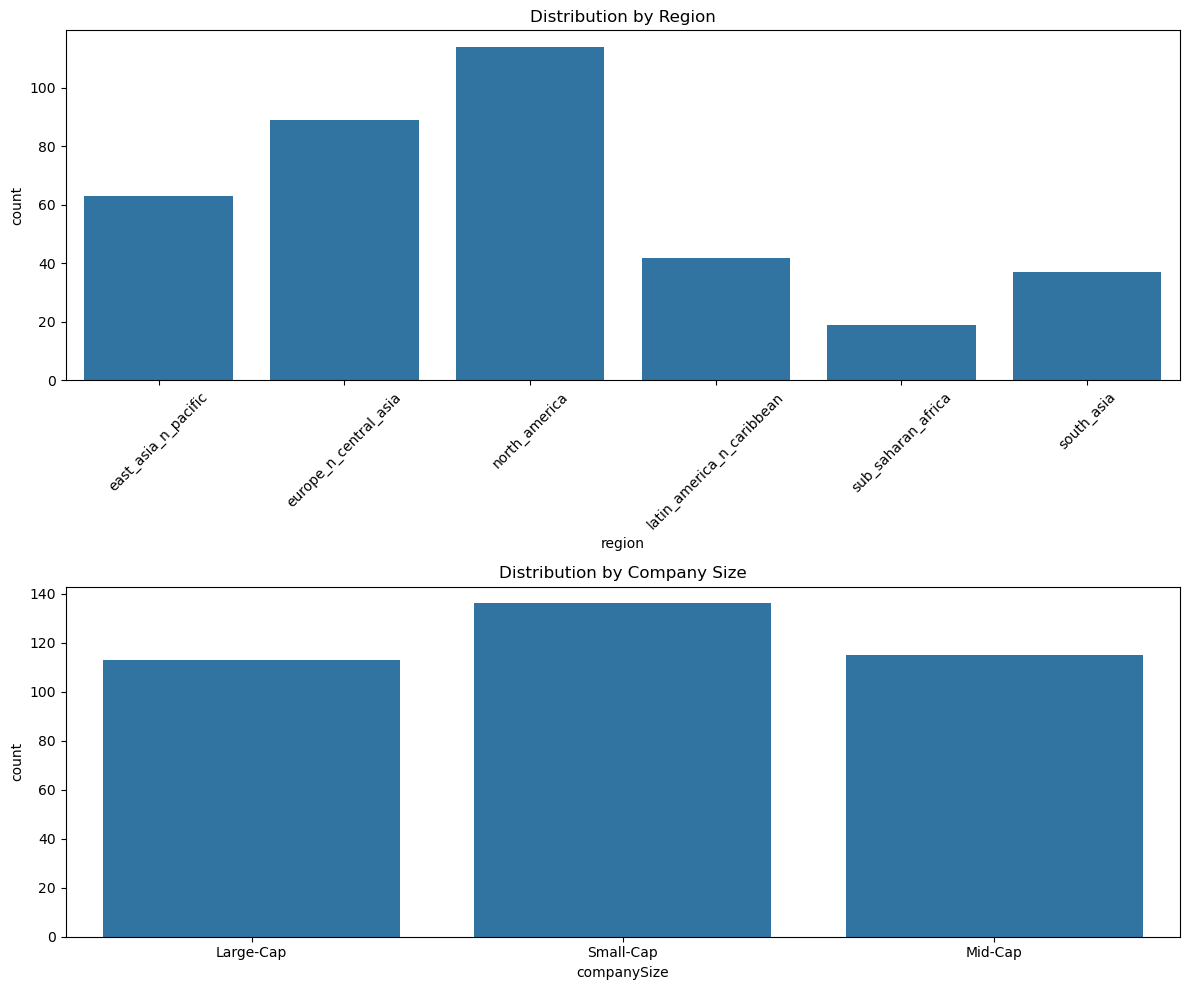

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot region distribution
sns.countplot(data=df_merged, x='region', ax=ax1)
ax1.set_title('Distribution by Region')
ax1.tick_params(axis='x', rotation=45)

# Plot company size distribution 
sns.countplot(data=df_merged, x='companySize', ax=ax2)
ax2.set_title('Distribution by Company Size')

plt.tight_layout()
plt.show()

### Correlation Clustering

In [46]:
df_latest = df_merged.copy()

In [47]:
df_latest.shape

(364, 242)

In [48]:
y = df_latest['totalEsg']
X = df_latest.drop(columns=['totalEsg', 'symbol', 'date', 'latest_year', 'environmentScore', 'socialScore', 'governanceScore', 'cleaned_text', 'raw_sentiment'])

In [49]:
num_df = X.select_dtypes(include=[np.number])

In [50]:
print(f"Categorical Features not considered: \n{set(X.columns) - set(num_df.columns)}")

Categorical Features not considered: 
{'gambling', 'militaryContract', 'region', 'controversialWeapons', 'companySize', 'peerEnvironmentPerformance', 'tobacco', 'relatedControversy', 'coal', 'palmOil', 'esgPerformance', 'peerGroup', 'pesticides', 'furLeather', 'nuclear', 'peerEsgScorePerformance', 'gmo', 'peerHighestControversyPerformance', 'peerGovernancePerformance', 'peerSocialPerformance', 'alcoholic', 'smallArms', 'animalTesting', 'adult'}


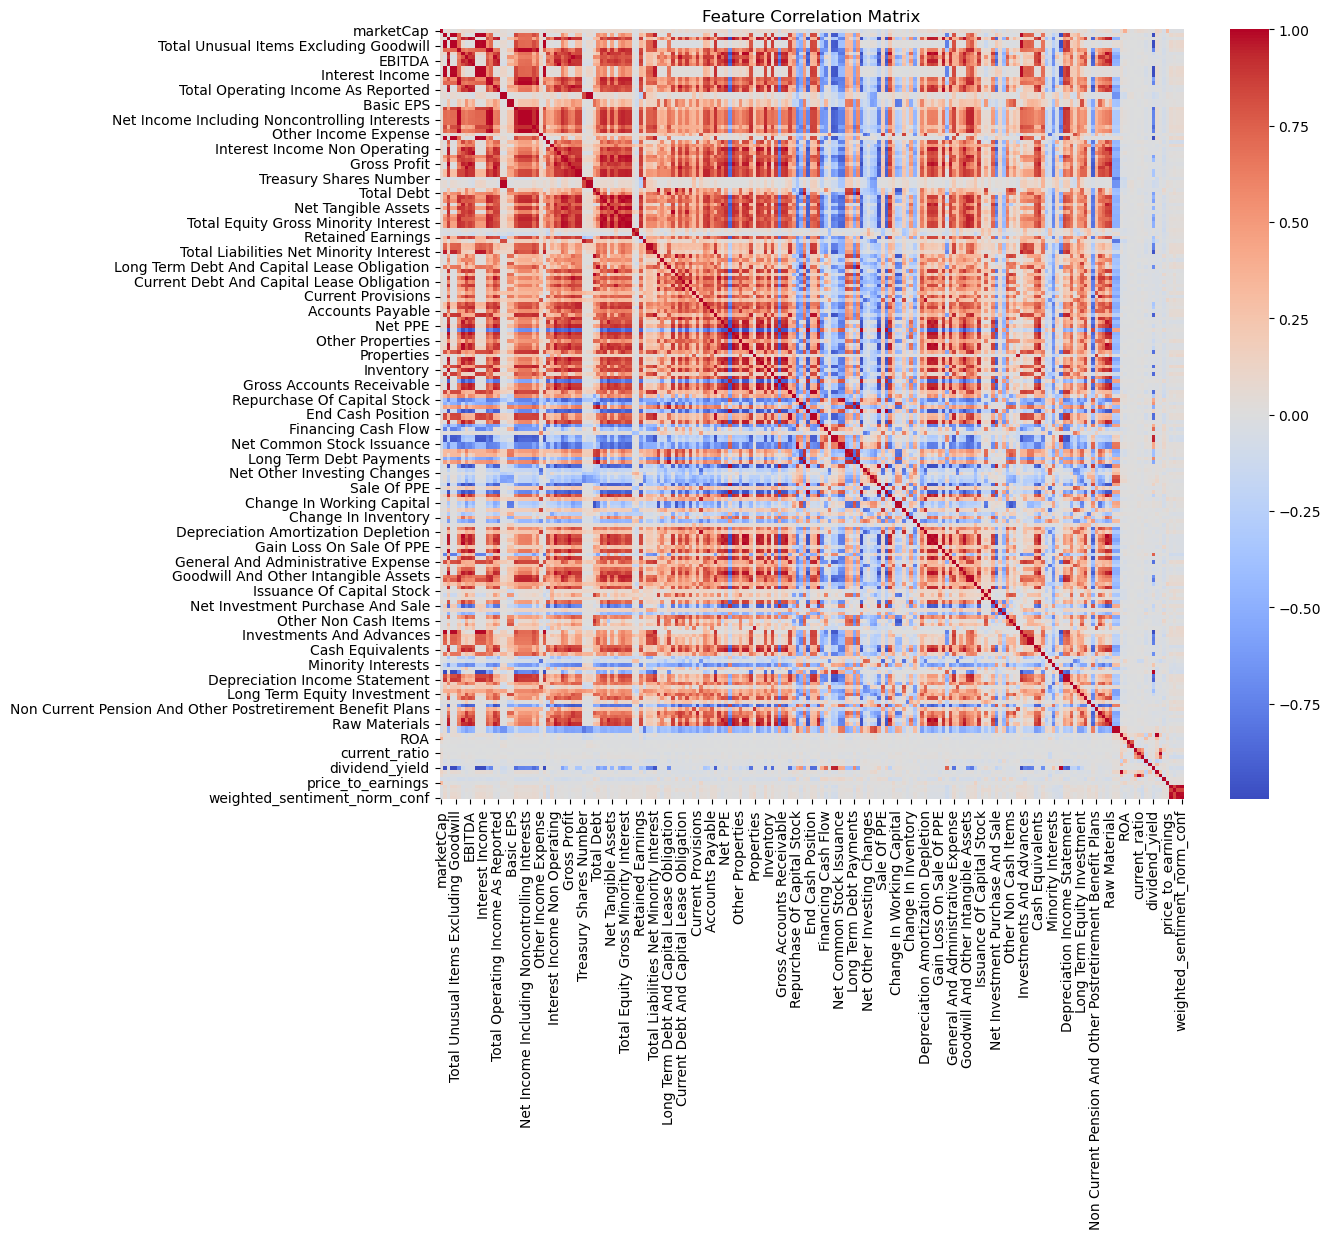

In [51]:
corr_matrix = num_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [52]:
# Convert to Distance Matrix 
corr_matrix = corr_matrix.fillna(0)
distance_matrix_full = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix_full.values, 0) # Ensure diagonal is zero
condensed_distance_matrix = squareform(distance_matrix_full, checks=False)

In [53]:
# Perform Hierarchical Clustering 
Z = linkage(condensed_distance_matrix, method='average') # Using 'average' linkage: uses the average of the distances between all pairs of points, one from each of the two sets of items.

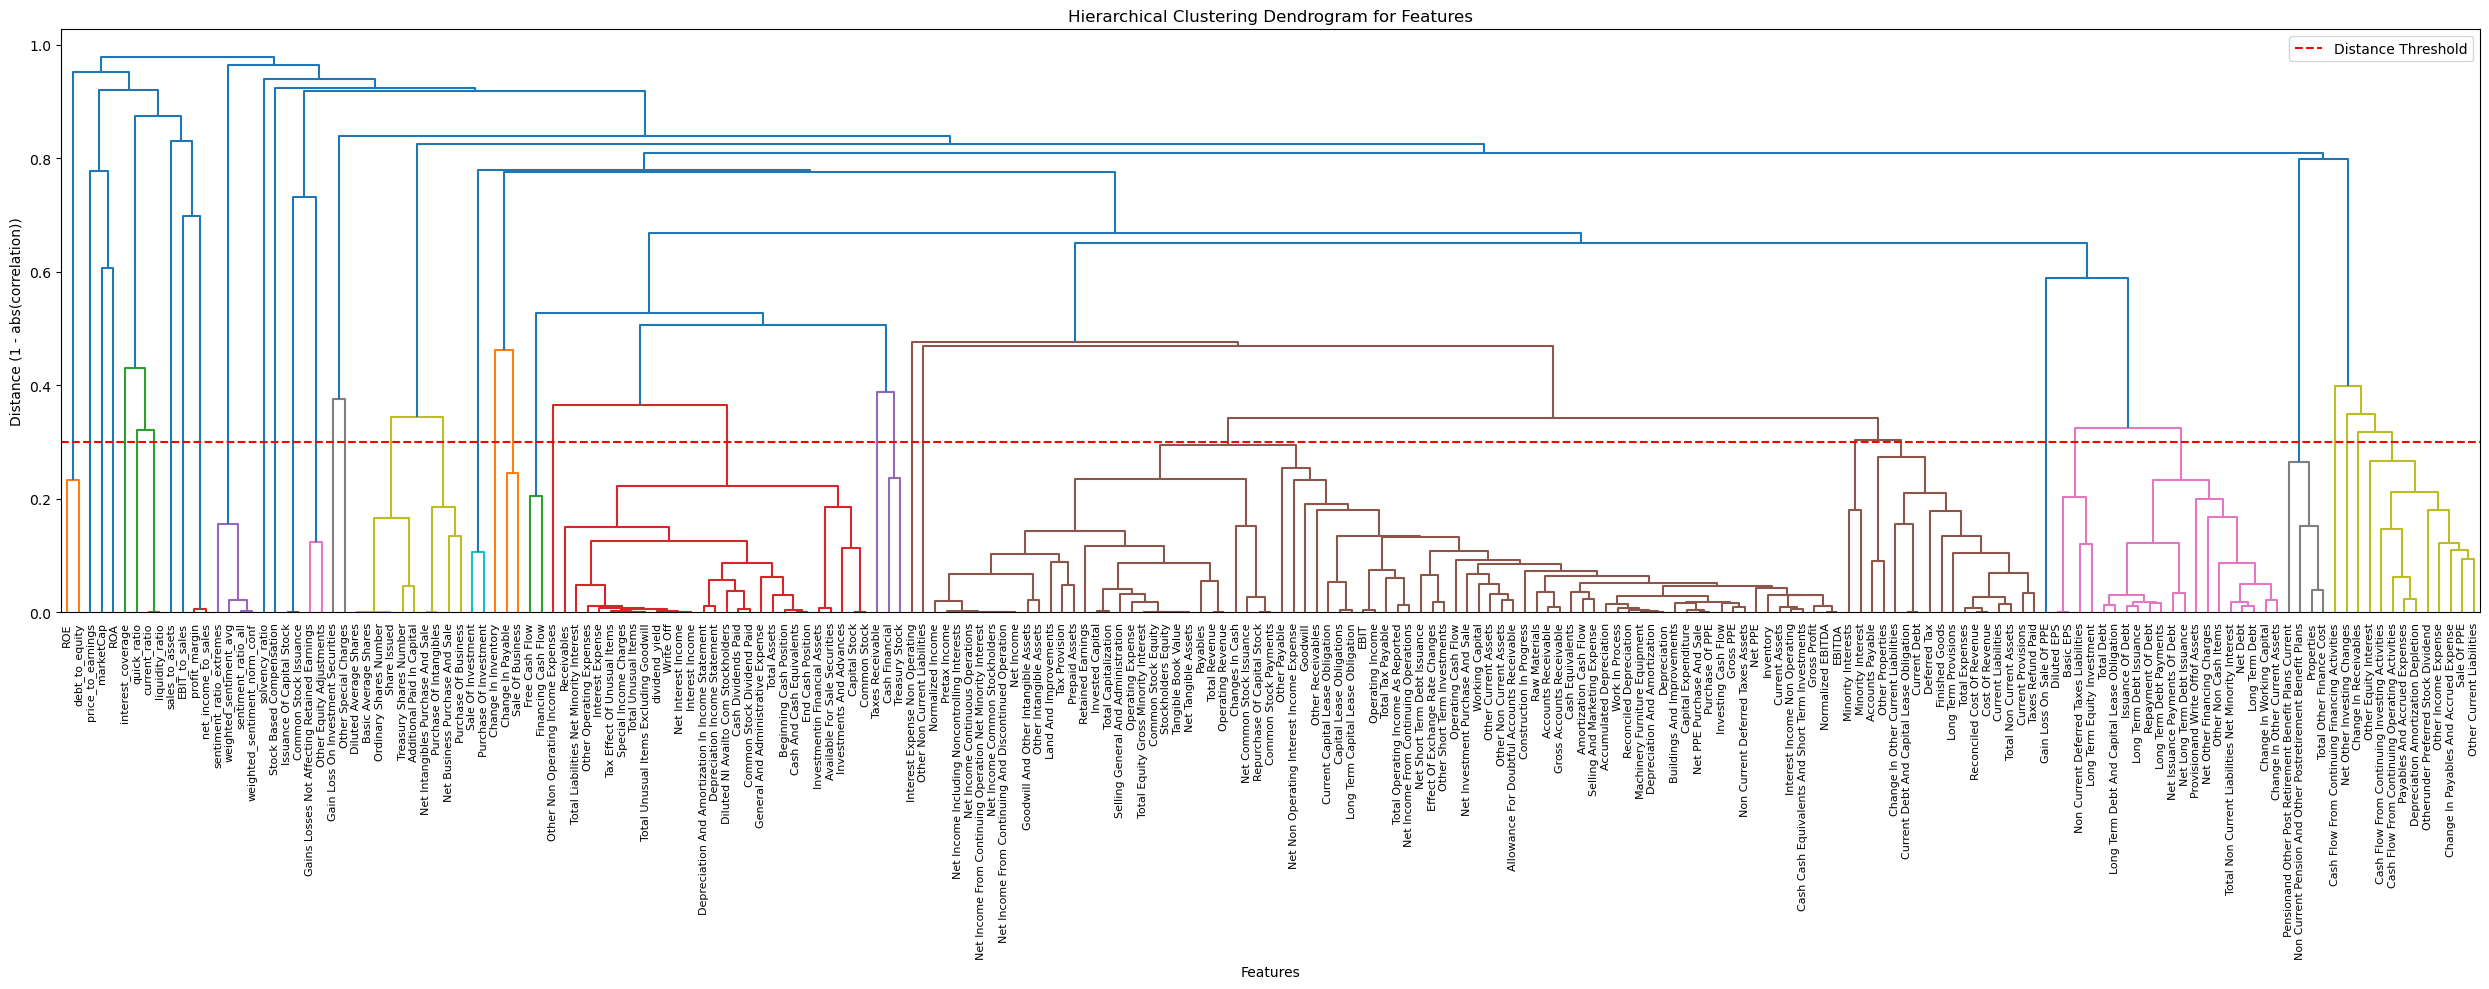

In [63]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram for Features')
plt.xlabel('Features')
plt.ylabel('Distance (1 - abs(correlation))')
dendrogram(
    Z,
    labels=corr_matrix.columns.tolist(),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold=0.5 
    # truncate_mode='lastp', p=50 # show only the last 50 merged clusters
)
plt.axhline(y=0.3, color='r', linestyle='--', label='Distance Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
# Form Flat Clusters 
distance_threshold = 0.30 # chosen based on dendrogram
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [65]:
# Create a mapping from cluster ID to feature names
cluster_map = pd.DataFrame({'Feature': corr_matrix.columns, 'ClusterID': clusters})
print(f"Number of clusters found: {cluster_map['ClusterID'].nunique()}")

Number of clusters found: 40


In [66]:
# Select Representative Features

# select the first feature encountered for each cluster
# representatives = cluster_map.drop_duplicates(subset=['ClusterID'], keep='first')['Feature'].tolist()

In [67]:
# select the feature with the highest mean absolute correlation with the target variable
y_aligned = y.loc[num_df.index]
target_correlations = num_df.corrwith(y_aligned).abs() # Calculate correlation and take absolute value
target_correlations = target_correlations.fillna(0) # Fill NaNs if any feature had zero variance
target_correlations.name = 'AbsCorrWithTarget' # Name the series

In [68]:
# add target correlation to the cluster map
cluster_map_with_corr = cluster_map.merge(target_correlations,
                                              left_on='Feature',
                                              right_index=True,
                                              how='left')

In [69]:
# Find the feature with the max absolute target correlation within each cluster
print("Selecting feature with highest absolute target correlation per cluster...")
# Sort by correlation within group to easily get max (idxmax handles ties by taking first)
# Using loc[groupby().idxmax()] is efficient
representatives_df = cluster_map_with_corr.loc[cluster_map_with_corr.groupby('ClusterID')['AbsCorrWithTarget'].idxmax()]
representatives = representatives_df['Feature'].tolist()

Selecting feature with highest absolute target correlation per cluster...


In [70]:
# Display the selected feature and its correlation for each cluster
print("\nRepresentative Features and their Absolute Correlation with Target:")
print(representatives_df[['ClusterID', 'Feature', 'AbsCorrWithTarget']].to_markdown(index=False))


Representative Features and their Absolute Correlation with Target:
|   ClusterID | Feature                                                    |   AbsCorrWithTarget |
|------------:|:-----------------------------------------------------------|--------------------:|
|           1 | debt_to_equity                                             |          0.0248025  |
|           2 | marketCap                                                  |          0.0356913  |
|           3 | ROA                                                        |          0.129077   |
|           4 | price_to_earnings                                          |          0.0244812  |
|           5 | current_ratio                                              |          0.130155   |
|           6 | quick_ratio                                                |          0.145922   |
|           7 | interest_coverage                                          |          0.0894148  |
|           8 | net_income_to_sales     

In [71]:
print(f"Number of representative features selected: {len(representatives)}")
# Ensure representatives are unique (should be by design, but check)
representatives = list(dict.fromkeys(representatives))
print(f"Final number of unique representative features: {len(representatives)}")
print("Selected Features:", representatives)

Number of representative features selected: 40
Final number of unique representative features: 40
Selected Features: ['debt_to_equity', 'marketCap', 'ROA', 'price_to_earnings', 'current_ratio', 'quick_ratio', 'interest_coverage', 'net_income_to_sales', 'EBIT_to_sales', 'sales_to_assets', 'sentiment_ratio_extremes', 'Common Stock Issuance', 'Other Equity Adjustments', 'Gain Loss On Investment Securities', 'Other Special Charges', 'Additional Paid In Capital', 'Purchase Of Business', 'Sale Of Investment', 'Sale Of Business', 'Change In Inventory', 'Financing Cash Flow', 'Special Income Charges', 'Other Non Operating Income Expenses', 'Cash Financial', 'Taxes Receivable', 'Changes In Cash', 'Minority Interest', 'Accounts Payable', 'Other Non Current Liabilities', 'Interest Expense Non Operating', 'Non Current Deferred Taxes Liabilities', 'Total Non Current Liabilities Net Minority Interest', 'Gain Loss On Sale Of PPE', 'Non Current Pension And Other Postretirement Benefit Plans', 'Other E

In [72]:
# Merge back the target variable and categorical features
final_features = ['symbol', 'date', 'region', 'companySize'] + representatives + list(set(financial_ratios.keys()) - set(representatives)) + ['totalEsg']
df_filtered = df_latest[final_features]

In [73]:
df_filtered.sort_index().head(10)

symbol        date               region companySize  debt_to_equity  \
0  000270.KS  2024-12-31  east_asia_n_pacific   Large-Cap        0.064407   
1    0005.HK  2024-12-31  east_asia_n_pacific   Small-Cap        1.260432   
2  000660.KS  2024-12-31  east_asia_n_pacific   Large-Cap        0.344340   
3  005380.KS  2024-12-31  east_asia_n_pacific   Large-Cap        1.311580   
4  005930.KS  2024-12-31  east_asia_n_pacific   Large-Cap        0.048062   
5  012330.KS  2024-12-31  east_asia_n_pacific   Large-Cap        0.077072   
6  021240.KS  2024-12-31  east_asia_n_pacific     Mid-Cap        0.463336   
7  035420.KS  2024-12-31  east_asia_n_pacific   Large-Cap        0.140805   
8  035720.KS  2024-12-31  east_asia_n_pacific     Mid-Cap        0.303852   
9  051910.KS  2024-12-31  east_asia_n_pacific     Mid-Cap        0.570389   

      marketCap       ROA  price_to_earnings  current_ratio  quick_ratio  ...  \
0  3.772784e+13  0.105362           3.867953       1.549352     1.089000  ...   
1  1.586861e+12  0.007948          77.609565       1.653200     1.365704  ...   
2  1.375858e+14  0.165105         -15.076853       1.693496     1.160202  ...   
3  5.030474e+13  0.036865           3.987367       0.809155     0.560242  ...   
4  3.968348e+14  0.065344          11.802230       2.432993     1.878435  ...   
5  2.420624e+13  0.060898           7.106987       2.230182     1.699555  ...   
6  6.112274e+12  0.098168          13.086985       0.943034     0.815169  ...   
7  2.948186e+13  0.050389          15.525124       1.538848     1.535279  ...   
8  1.806765e+13  0.002145         -17.777238       1.269460     1.261941  ...   
9  1.920612e+13 -0.007361         -30.826065       1.319169     0.899575  ...   

   Change In Receivables  Net Other Investing Changes  \
0          -1.073396e+12                 1.174000e+06   
1          -8.108500e+09                -9.650000e+08   
2          -5.084288e+12                 1.187860e+11   
3          -5.900450e+11                -4.222010e+11   
4          -3.138734e+12                 1.186770e+11   
5           3.345800e+11                 2.499800e+10   
6           1.427374e+11                 7.839717e+08   
7          -2.827538e+09                 1.387750e+10   
8          -2.034548e+10                 2.413729e+10   
9           7.350130e+11                 5.746760e+11   

   Cash Flow From Continuing Financing Activities  Stock Based Compensation  \
0                                   -2.078016e+11              1.226851e+10   
1                                   -1.749844e+09              5.290000e+08   
2                                   -2.078016e+11              2.491000e+09   
3                                   -2.078016e+11              1.226851e+10   
4                                   -2.078016e+11              1.226851e+10   
5                                   -2.078016e+11              1.226851e+10   
6                                   -3.191975e+11              7.041400e+07   
7                                   -2.078016e+11              2.190005e+11   
8                                   -3.191975e+11              7.327506e+10   
9                                   -3.191975e+11              1.624000e+09   

   solvency_ratio       ROE  liquidity_ratio  dividend_yield  profit_margin  \
0        0.038774  0.175045         1.549352       -0.058161       0.090955   
1        0.080326  0.123894         1.653200       -0.010776       0.354687   
2        0.212357  0.267764         1.693496       -0.006006       0.298954   
3        0.464250  0.115164         0.809155       -0.077791       0.071487   
4        0.037568  0.085863         2.432993       -0.027439       0.111747   
5        0.053373  0.088012         2.230182       -0.016782       0.070857   
6        0.257027  0.176839         0.943034       -0.016027       0.131225   
7        0.099609  0.075540         1.538848       -0.004036       0.179110   
8        0.164380  0.005451         1.269460       -0.002

### Categorical Encoding

In [74]:
categorical_cols = ['region', 'companySize']
X_cat = df_filtered[categorical_cols]

In [75]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X_cat)

In [76]:
X_cat_encoded_df = pd.DataFrame(X_cat_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_cols))
X_cat_encoded_df = X_cat_encoded_df.set_index(df_filtered.index)

In [77]:
df_encoded = pd.concat([df_filtered.drop(columns=categorical_cols), X_cat_encoded_df], axis=1)
df_encoded.sort_index().head(10)
# df_encoded = df_filtered.copy()

symbol        date  debt_to_equity     marketCap       ROA  \
0  000270.KS  2024-12-31        0.064407  3.772784e+13  0.105362   
1    0005.HK  2024-12-31        1.260432  1.586861e+12  0.007948   
2  000660.KS  2024-12-31        0.344340  1.375858e+14  0.165105   
3  005380.KS  2024-12-31        1.311580  5.030474e+13  0.036865   
4  005930.KS  2024-12-31        0.048062  3.968348e+14  0.065344   
5  012330.KS  2024-12-31        0.077072  2.420624e+13  0.060898   
6  021240.KS  2024-12-31        0.463336  6.112274e+12  0.098168   
7  035420.KS  2024-12-31        0.140805  2.948186e+13  0.050389   
8  035720.KS  2024-12-31        0.303852  1.806765e+13  0.002145   
9  051910.KS  2024-12-31        0.570389  1.920612e+13 -0.007361   

   price_to_earnings  current_ratio  quick_ratio  interest_coverage  \
0           3.867953       1.549352     1.089000         134.021323   
1          77.609565       1.653200     1.365704           1.363844   
2         -15.076853       1.693496     1.160202          18.755469   
3           3.987367       0.809155     0.560242          40.383200   
4          11.802230       2.432993     1.878435          42.518959   
5           7.106987       2.230182     1.699555          41.720244   
6          13.086985       0.943034     0.815169          13.503156   
7          15.525124       1.538848     1.535279          23.141056   
8         -17.777238       1.269460     1.261941           0.986182   
9         -30.826065       1.319169     0.899575           0.718968   

   net_income_to_sales  ...  totalEsg  region_east_asia_n_pacific  \
0             0.090955  ...     24.55                         1.0   
1             0.354687  ...     24.22                         1.0   
2             0.298954  ...     17.67                         1.0   
3             0.071487  ...     28.31                         1.0   
4             0.111747  ...     19.41                         1.0   
5             0.070857  ...     14.40                         1.0   
6             0.131225  ...     18.20                         1.0   
7             0.179110  ...     14.81                         1.0   
8             0.007022  ...     20.93                         1.0   
9            -0.014123  ...     26.64                         1.0   

   region_europe_n_central_asia  region_latin_america_n_caribbean  \
0                           0.0                               0.0   
1                           0.0                               0.0   
2                           0.0                               0.0   
3                           0.0                               0.0   
4                           0.0                               0.0   
5                           0.0                               0.0   
6                           0.0                               0.0   
7                           0.0                               0.0   
8                           0.0                               0.0   
9                           0.0                               0.0   

   region_north_america  region_south_asia  region_sub_saharan_africa  \
0                   0.0                0.0                        0.0   
1                   0.0                0.0                        0.0   
2                   0.0                0.0                        0.0   
3                   0.0                0.0                        0.0   
4                   0.0                0.0                        0.0   
5                   0.0                0.0                        0.0   
6                   0.0                0.0                        0.0   
7                   0.0                0.0                        0.0   
8                   0.0                0.0                        0.0   
9                   0.0                0.0                        0.0   

   companySize_Large-Cap  companySize_Mid-Cap  companySize_Small-Cap  
0                    1.0                  0.0                    0.0  
1        

### Feature Scaling

In [78]:
all_numerical_cols = df_encoded.select_dtypes(include=np.number).columns.tolist()
 # check the index of the target variable

In [ ]:
all_numerical_cols = all_numerical_cols[:all_numerical_cols.index("totalEsg")] # exclude the target and OHE categorical features

In [80]:
all_numerical_cols

['debt_to_equity',
 'marketCap',
 'ROA',
 'price_to_earnings',
 'current_ratio',
 'quick_ratio',
 'interest_coverage',
 'net_income_to_sales',
 'EBIT_to_sales',
 'sales_to_assets',
 'sentiment_ratio_extremes',
 'Common Stock Issuance',
 'Other Equity Adjustments',
 'Gain Loss On Investment Securities',
 'Other Special Charges',
 'Additional Paid In Capital',
 'Purchase Of Business',
 'Sale Of Investment',
 'Sale Of Business',
 'Change In Inventory',
 'Financing Cash Flow',
 'Special Income Charges',
 'Other Non Operating Income Expenses',
 'Cash Financial',
 'Taxes Receivable',
 'Changes In Cash',
 'Minority Interest',
 'Accounts Payable',
 'Other Non Current Liabilities',
 'Interest Expense Non Operating',
 'Non Current Deferred Taxes Liabilities',
 'Total Non Current Liabilities Net Minority Interest',
 'Gain Loss On Sale Of PPE',
 'Non Current Pension And Other Postretirement Benefit Plans',
 'Other Equity Interest',
 'Change In Receivables',
 'Net Other Investing Changes',
 'Cash F

In [81]:
# Identify highly skewed, non-negative numerical columns for log1p
skewness = df_encoded[all_numerical_cols].skew()

skew_threshold = 1.0
log1p_candidates = skewness[abs(skewness) > skew_threshold].index.tolist()

In [82]:
len(log1p_candidates), len(all_numerical_cols)

(40, 44)

In [83]:
log1p_cols = []
neg_cols = []
for col in log1p_candidates:
    if df_encoded[col].min() >= 0:
        log1p_cols.append(col)
    else:
        neg_cols.append(col)
        continue

In [84]:
len(log1p_cols), len(neg_cols)

(13, 27)

In [85]:
other_numerical_cols = [col for col in all_numerical_cols if col not in log1p_cols]
len(other_numerical_cols)

31

In [86]:
print(set(neg_cols) - set(other_numerical_cols))
print(set(other_numerical_cols) - set(neg_cols))

set()
{'ROE', 'sentiment_ratio_extremes', 'price_to_earnings', 'quick_ratio'}


In [87]:
# Apply log1p transformation to the selected columns
df_transformed = df_encoded.copy()
df_transformed[log1p_cols] = np.log1p(df_encoded[log1p_cols])

In [88]:
numerical_cols_to_scale = log1p_cols + other_numerical_cols
# scaler = RobustScaler()
scaler = StandardScaler()
scaler.fit(df_transformed[numerical_cols_to_scale].dropna())

StandardScaler()

In [89]:
transformed_data = scaler.transform(df_transformed[numerical_cols_to_scale])

# Create a temporary DataFrame with transformed data and original index/columns
transformed_df = pd.DataFrame(transformed_data,
                                index=df_transformed.index,
                                columns=numerical_cols_to_scale)

# Update the original copied dataframe with the scaled values
df_transformed.update(transformed_df)

In [90]:
df_transformed.sort_index().head(10)

symbol        date  debt_to_equity  marketCap       ROA  \
0  000270.KS  2024-12-31       -0.157335   1.942613  0.544856   
1    0005.HK  2024-12-31        0.097658   0.592456 -0.685504   
2  000660.KS  2024-12-31       -0.097653   2.493922  1.299417   
3  005380.KS  2024-12-31        0.108563   2.065202 -0.320274   
4  005930.KS  2024-12-31       -0.160820   2.945278  0.039414   
5  012330.KS  2024-12-31       -0.154635   1.753515 -0.016730   
6  021240.KS  2024-12-31       -0.072283   1.167069  0.453990   
7  035420.KS  2024-12-31       -0.141047   1.837527 -0.149466   
8  035720.KS  2024-12-31       -0.106285   1.628886 -0.758797   
9  051910.KS  2024-12-31       -0.049459   1.654923 -0.878853   

   price_to_earnings  current_ratio  quick_ratio  interest_coverage  \
0          -0.064354       0.063022    -0.005920           0.216956   
1          -0.053918       0.170119     0.102114          -0.110233   
2          -0.067036       0.210551     0.021879          -0.067338   
3          -0.064337      -0.856954    -0.212365          -0.013995   
4          -0.063231       0.861259     0.302301          -0.008727   
5          -0.063896       0.697922     0.232460          -0.010697   
6          -0.063049      -0.665462    -0.112833          -0.080292   
7          -0.062704       0.051948     0.168322          -0.056521   
8          -0.067418      -0.248924     0.061601          -0.111164   
9          -0.069264      -0.190806    -0.079878          -0.111823   

   net_income_to_sales  ...  totalEsg  region_east_asia_n_pacific  \
0            -0.198089  ...     24.55                         1.0   
1             1.104910  ...     24.22                         1.0   
2             0.829555  ...     17.67                         1.0   
3            -0.294273  ...     28.31                         1.0   
4            -0.095363  ...     19.41                         1.0   
5            -0.297383  ...     14.40                         1.0   
6             0.000873  ...     18.20                         1.0   
7             0.237453  ...     14.81                         1.0   
8            -0.612765  ...     20.93                         1.0   
9            -0.717237  ...     26.64                         1.0   

   region_europe_n_central_asia  region_latin_america_n_caribbean  \
0                           0.0                               0.0   
1                           0.0                               0.0   
2                           0.0                               0.0   
3                           0.0                               0.0   
4                           0.0                               0.0   
5                           0.0                               0.0   
6                           0.0                               0.0   
7                           0.0                               0.0   
8                           0.0                               0.0   
9                           0.0                               0.0   

   region_north_america  region_south_asia  region_sub_saharan_africa  \
0                   0.0                0.0                        0.0   
1                   0.0                0.0                        0.0   
2                   0.0                0.0                        0.0   
3                   0.0                0.0                        0.0   
4                   0.0                0.0                        0.0   
5                   0.0                0.0                        0.0   
6                   0.0                0.0                        0.0   
7                   0.0                0.0                        0.0   
8                   0.0                0.0                        0.0   
9                   0.0                0.0                        0.0   

   companySize_Large-Cap  companySize_Mid-Cap  companySize_Small-Cap  
0                    1.0                  0.0                    0.0  
1                    0.0                  

In [91]:
import random

Distribution Plots (Histogram + Density)


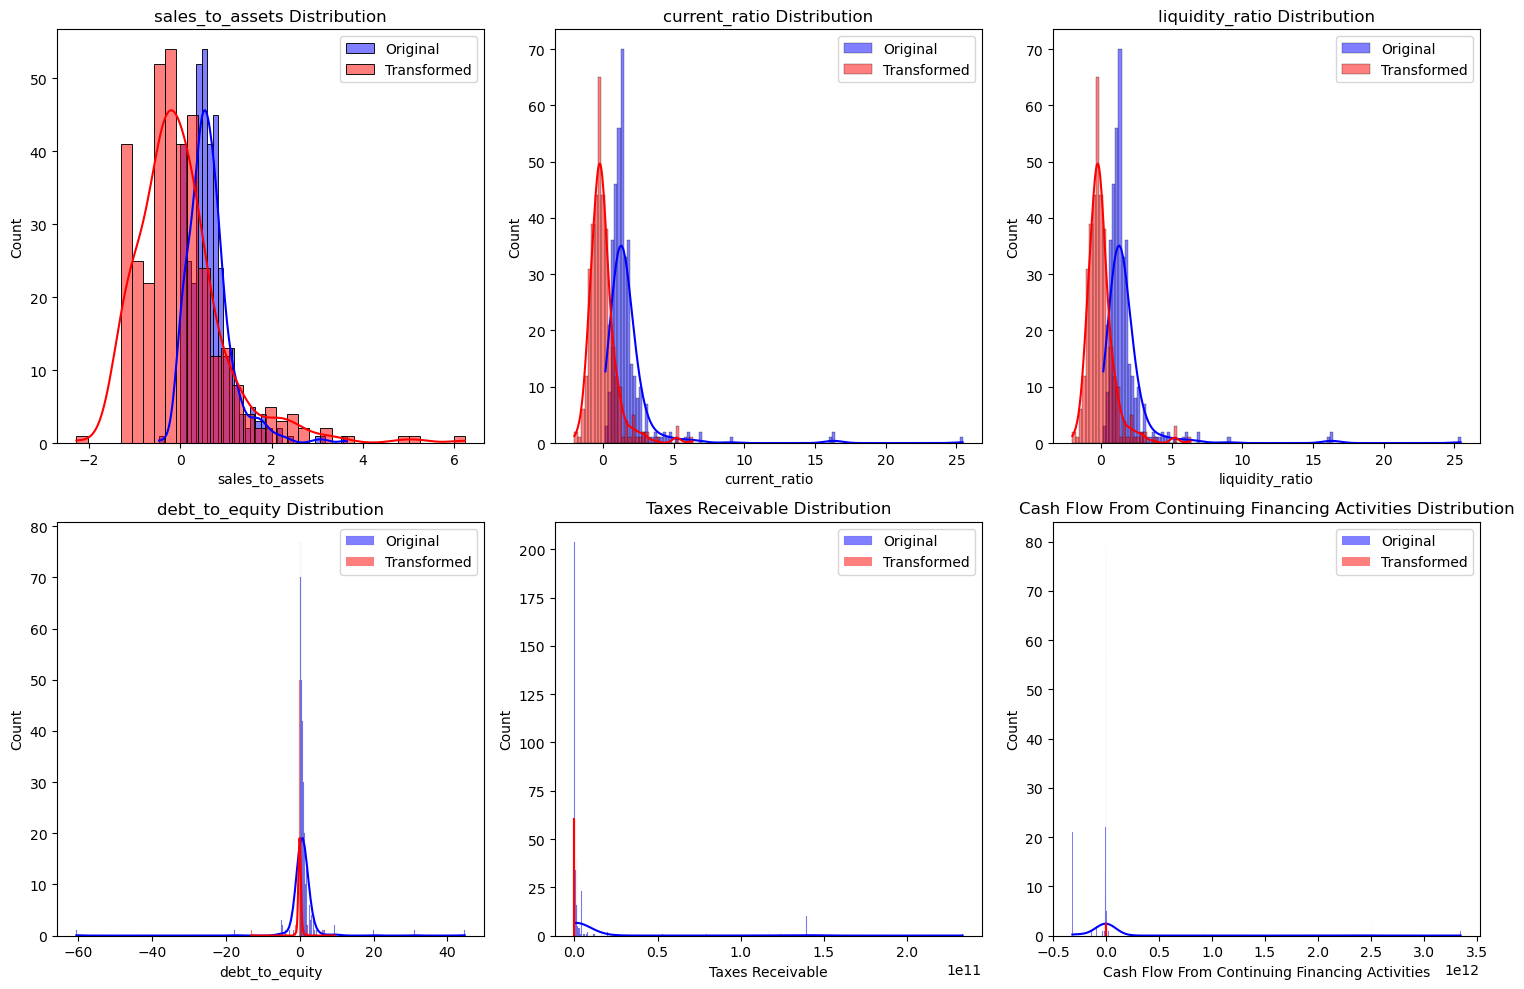


Violin Plots Comparison


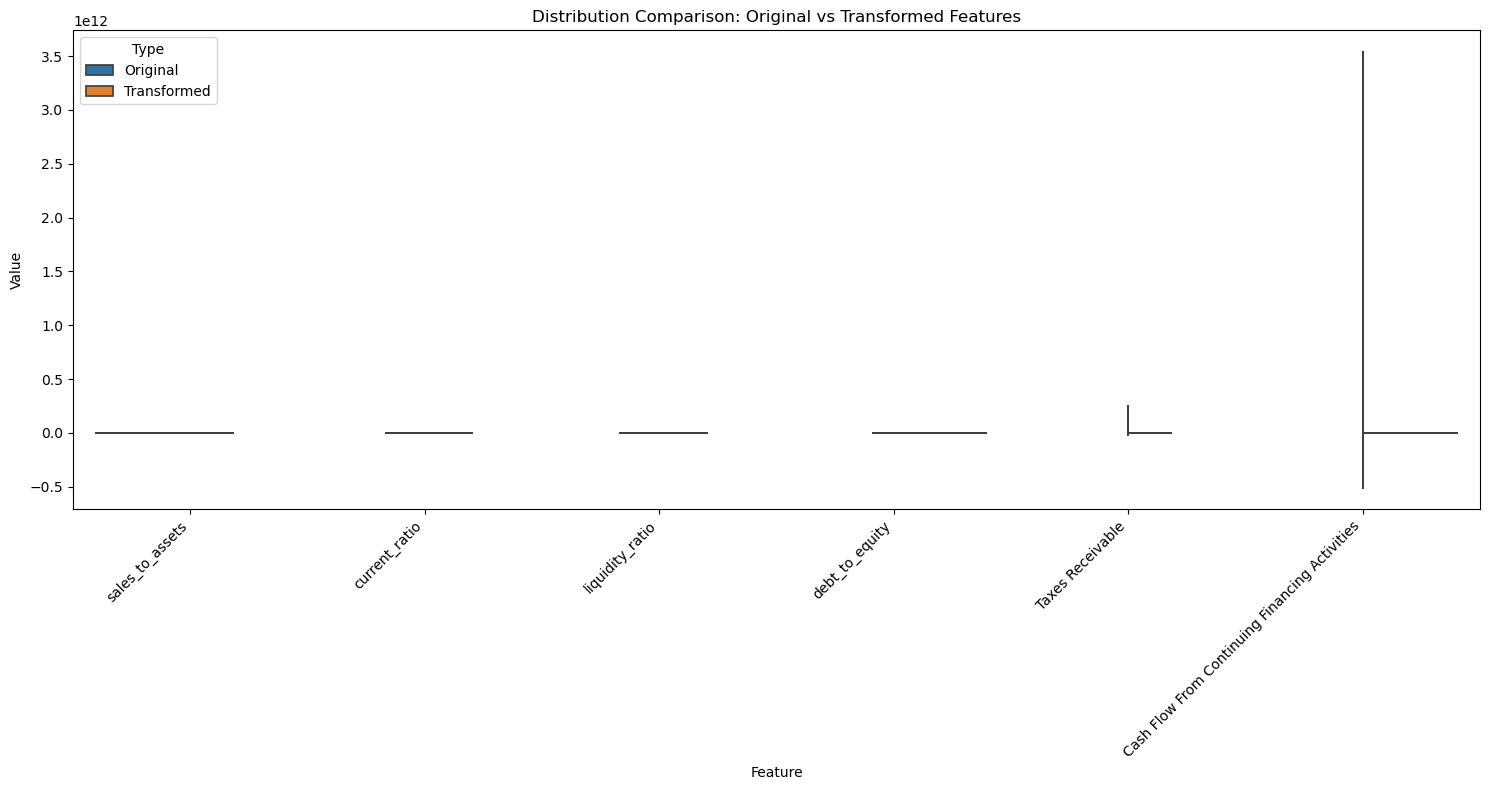

In [ ]:
def plot_feature_transformations(df_original, df_transformed, features, n_cols=3):
    """
    Plot histograms and density plots for features before and after transformation.
    
    Args:
        df_original: Original dataframe
        df_transformed: Transformed dataframe
        features: List of features to plot
        n_cols: Number of columns in the subplot grid
    """
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.ravel()
    
    for idx, feature in enumerate(features):
        # Plot original distribution
        sns.histplot(df_original[feature], kde=True, ax=axes[idx], 
                    label='Original', alpha=0.5, color='blue')
        
        # Plot transformed distribution
        sns.histplot(df_transformed[feature], kde=True, ax=axes[idx], 
                    label='Transformed', alpha=0.5, color='red')
        
        axes[idx].set_title(f'{feature} Distribution')
        axes[idx].legend()
    
    # Remove empty subplots
    for idx in range(len(features), len(axes)):
        fig.delaxes(axes[idx])
        
    plt.tight_layout()
    plt.show()

def plot_violin_comparison(df_original, df_transformed, features):
    """
    Create violin plots comparing original and transformed distributions.
    
    Args:
        df_original: Original dataframe
        df_transformed: Transformed dataframe
        features: List of features to plot
    """
    # Prepare data for violin plots
    original_data = df_original[features].melt(var_name='Feature', value_name='Value')
    original_data['Type'] = 'Original'
    
    transformed_data = df_transformed[features].melt(var_name='Feature', value_name='Value')
    transformed_data['Type'] = 'Transformed'
    
    combined_data = pd.concat([original_data, transformed_data])
    
    # Create violin plots
    plt.figure(figsize=(15, 8))
    sns.violinplot(data=combined_data, x='Feature', y='Value', hue='Type', 
                  split=True, inner='quartile')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution Comparison: Original vs Transformed Features')
    plt.tight_layout()
    plt.show()

# Sample a few features to visualize (e.g., 6 features)
sample_features = random.sample(numerical_cols_to_scale, 6)

# Create the visualizations
print("Distribution Plots (Histogram + Density)")
plot_feature_transformations(df_encoded, df_transformed, sample_features)

print("\nViolin Plots Comparison")
plot_violin_comparison(df_encoded, df_transformed, sample_features)

In [100]:
df_transformed.to_csv("../data/processed/preprocessed_features_3.csv", index=False)